In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  8 18:46:22 2019


Load MNIST dataset and implement an autoencoder with only a few layers to do manifold learning

@author: rvulling
"""

import struct as st
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import clear_output
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, AvgPool2D, UpSampling2D, ReLU, MaxPooling2D, \
    Reshape, Softmax, Activation, Flatten, Lambda, Conv2DTranspose
from tensorflow.keras.losses import MSE, categorical_crossentropy, binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import sklearn
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.datasets import mnist

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

args = {
    'epochs': 10,
    'batch_size': 64
}


def build_batches(x, n):
    m = (x.shape[0] // n) * n
    return x[:m].reshape(-1, n, *x.shape[1:])


def get_mnist32_batches(batch_size, data_format='channels_last'):
    maxNum_data_train = 10000  # reduce data size for computational load
    maxNum_data_test = 1000
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    data_x_train = X_train.reshape(-1, 28, 28).astype(np.float32) / 255.
    data_x_test = X_test.reshape(-1, 28, 28).astype(np.float32) / 255.

    # Reduce dimensions of dataset to reduce computations times
    np.random.seed(42)  # seed to ensure reproducible results
    randomIndices_train = np.random.permutation(np.size(data_x_train, 0))
    randomIndices_test = np.random.permutation(np.size(data_x_test, 0))
    indicesTrain = randomIndices_train[0:maxNum_data_train]
    indicesTest = randomIndices_test[0:maxNum_data_test]
    data_x_train = data_x_train[indicesTrain, :, :]  # Reduce dimensions of dataset to reduce computations times
    data_x_train = np.pad(data_x_train, ((0, 0), (2, 2), (2, 2)), mode='constant')
    data_x_train = np.expand_dims(data_x_train, -1)
    data_x_test = data_x_test[indicesTest, :, :]
    data_x_test = np.pad(data_x_test, ((0, 0), (2, 2), (2, 2)), mode='constant')
    data_x_test = np.expand_dims(data_x_test, -1)
    data_y_train = Y_train[indicesTrain]  # Reduce dimensions of dataset to reduce computations times
    data_y_test = Y_test[indicesTest]  # Reduce dimensions of dataset to reduce computations times
    indices = np.arange(len(data_x_train))
    # np.random.shuffle(indices)
    y_batches = build_batches(data_y_train[indices], batch_size)
    x_batches = build_batches(data_x_train[indices], batch_size)
    return x_batches, y_batches, data_x_train, data_y_train, data_x_test, data_y_test


x_batches, y_batches, data_x_train, data_y_train, data_x_test, data_y_test = get_mnist32_batches(args['batch_size'])


def Encoder(input_shape):
    print(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_shape)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    encode = MaxPooling2D((2, 1))(x)
    print(encode.shape)
    return encode

def Decoder(input_shape):
    print(input_shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(input_shape)
    print(x.shape)
    x = UpSampling2D((2, 1))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    decode = Conv2DTranspose(1, (3, 3), activation='relu', padding='same')(x)
    print(decode.shape)
    return decode

"""
Create models    
"""
input_shape = x_batches.shape[2:]


inputs = Input(input_shape)
encoded = Encoder(inputs)
decoded = Decoder(encoded)
model = tf.keras.Model(inputs=inputs, outputs=decoded)

model.compile('adam', loss= MSE)
#model.compile('adam', loss=lambda yt, yp: MSE(inputs, decoded))

"""
Train model or load weights of previously trained model
"""

history = model.fit(data_x_train, data_x_train,
              epochs=10,
              batch_size=64,
              shuffle=True,
              validation_data=(data_x_test, data_x_test))


Tensor("input_1:0", shape=(None, 32, 32, 1), dtype=float32)
(None, 32, 32, 16)
(None, 16, 16, 16)
(None, 16, 16, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 2, 2, 16)
(None, 2, 2, 1)
(None, 1, 2, 1)
Tensor("max_pooling2d_4/MaxPool:0", shape=(None, 1, 2, 1), dtype=float32)
(None, 1, 2, 16)
(None, 2, 2, 16)
(None, 2, 2, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 16, 16, 16)
(None, 16, 16, 16)
(None, 32, 32, 16)
(None, 32, 32, 1)
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0504

c:\users\20174215\documents\vakken\master jaar 1\q4\5lsl0\autoencoder\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 26s 3ms/sample - loss: 0.0504 - val_loss: 0.0449
Epoch 2/10
10000/10000 [==============================] - 18s 2ms/sample - loss: 0.0441 - val_loss: 0.0439
Epoch 3/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0430 - val_loss: 0.0428
Epoch 4/10
10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0423 - val_loss: 0.0428
Epoch 5/10
10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0415 - val_loss: 0.0416
Epoch 6/10
10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0408 - val_loss: 0.0406
Epoch 7/10
  640/10000 [>.............................] - ETA: 9s - loss: 0.0411

In [46]:
# Encode and decode some digits
# Note that we take them from the *test* set


decoded_imgs = model.predict(x_batches[0,0:10])

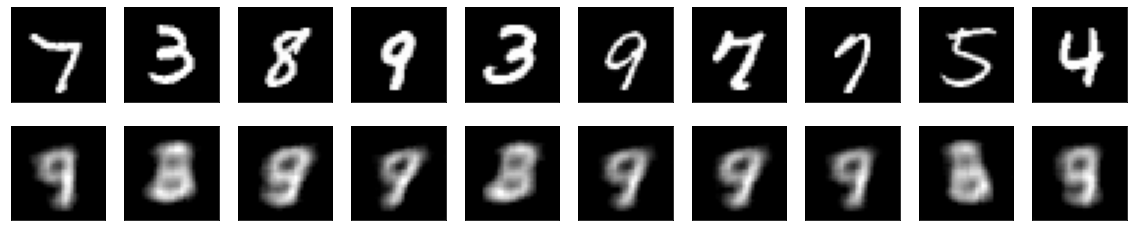

In [47]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_batches[0,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig("autoencoder_reconstruction.png")
plt.show()

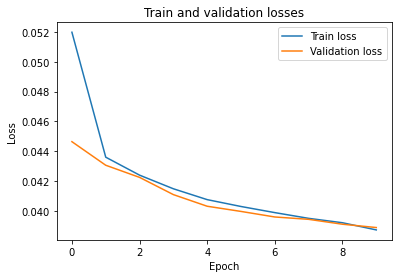

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and validation losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig('Train_and_val_losses.png')
plt.show()